## Title 
Bayesian Example Notebook

## Description :
This notebook provides example code based on the lecture material.

If you wish to run or edit the notebook, we recommend downloading it and running it either on your local machine or on JupyterHub.

In [2]:
import pymc3 as pm

In [1]:
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
n_theta = 10000

# generate 10,000 values from Beta(2,5)
theta = np.random.beta(2,5,n_theta) 
print("First five  values of theta:\n\t", theta[0:5])
print("Sample mean:\n\t", np.mean(theta))
print("The 2.5% and 97.5% of quantiles:\n\t", np.percentile(theta,[2.5,97.5])) 

First five  values of theta:
	 [0.09380107 0.09315237 0.43342451 0.40271348 0.1825154 ]
Sample mean:
	 0.2846024748126768
The 2.5% and 97.5% of quantiles:
	 [0.04172583 0.63937365]


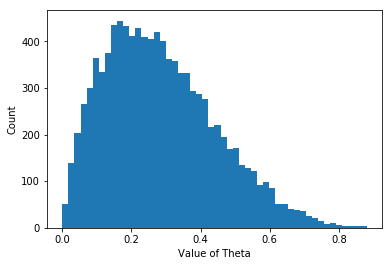

In [4]:
plt.hist(theta,50)
plt.xlabel("Value of Theta")
plt.ylabel("Count")
plt.show()

First 5 heads/tails values (tails=0, heads=1)
	 [0 0 0 0 0 1 0 0 0 0]
Overall frequency of Tails and Heads, accounting for uncertainty about theta itself
	 [0.7163 0.2837]


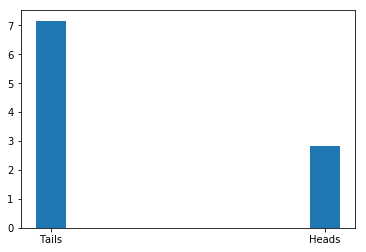

In [5]:
# simulate y from posterior predictive distribution
y = np.random.binomial(1, theta, n_theta) # generate a heads/tails value from each of the 10,000 thetas

print("First 5 heads/tails values (tails=0, heads=1)\n\t", y[0:10])
print("Overall frequency of Tails and Heads, accounting for uncertainty about theta itself\n\t", np.bincount(y)/10000)

plt.hist(y, density=True)
plt.xticks([.05,.95],["Tails","Heads"])
plt.show()

## Rejection sampling and Weighted bootstrap

Example adapted from https://wiseodd.github.io/techblog/2015/10/21/rejection-sampling/

In [2]:
sns.set()

def h(x):
    return st.norm.pdf(x, loc=30, scale=10) + st.norm.pdf(x, loc=80, scale=20)


def g(x):
    return st.norm.pdf(x, loc=50, scale=30)


x = np.arange(-50, 151)
M = max(h(x) / g(x))  # for rejection sampling

h is a mixture of two normal distributions (unnormalized), and density h is a normal distribution with mean 50 and standard deviation 30.

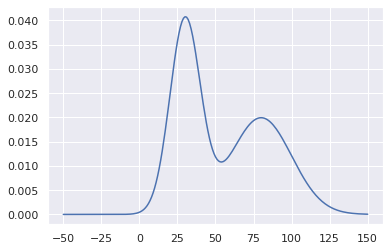

In [17]:
plt.plot(x, h(x))
plt.show()

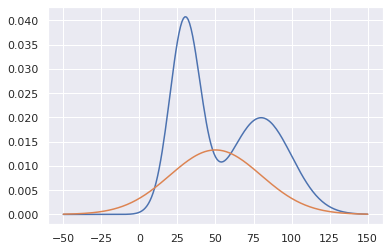

In [18]:
# Superimpose h and g on same plot
plt.plot(x,h(x))
plt.plot(x,g(x))
plt.show()

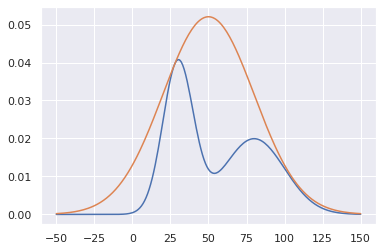

In [19]:
# Superimpose h and M*g on same plot - now M*g envelopes h
plt.plot(x,h(x))
plt.plot(x,M*g(x))
plt.show()

Rejection rate is 49.54591321897074


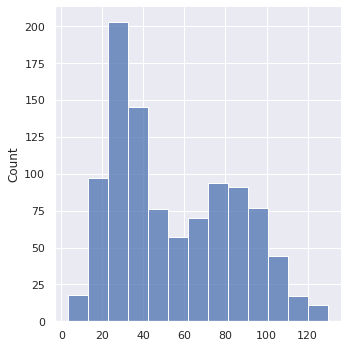

In [5]:
def rejection_sampling(maxiter=10000,sampsize=1000):
    samples = []
    sampcount = 0  # counter for accepted samples
    maxcount = 0   # counter for proposal simulation
    # sampcount/maxcount at any point in the iteration is the acceptance rate

    while (sampcount < sampsize and maxcount < maxiter):
        z = np.random.normal(50, 30)
        u = np.random.uniform(0, 1)
        maxcount += 1

        if u <= h(z)/(M*g(z)):
            samples.append(z)
            sampcount += 1
    
    print('Rejection rate is',100*(1-sampcount/maxcount))
    if maxcount == maxiter: print('Maximum iterations achieved')
    return np.array(samples)

s = rejection_sampling(maxiter=10000,sampsize=1000)
sns.displot(s)

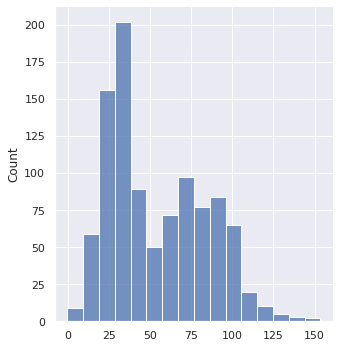

In [25]:
# weighted bootstrap computation involving h and g
import random

def weighted_bootstrap(iter=1000,size=100):
    w = []
    y = []
    
    for i in range(iter):
        z = np.random.normal(50, 30)
        y.append(z)
        wz = h(z)/g(z)
        w.append(wz)
        
    v = random.choices(y,weights=w,k=size) # do not need to renormalize w
    return np.array(v)

wb = weighted_bootstrap(iter=10000,size=1000)
sns.displot(wb)

## Beetles

In [5]:
beetles_x = np.array([1.6907, 1.7242, 1.7552, 1.7842, 1.8113, 1.8369, 1.8610, 1.8839])
beetles_x_mean = beetles_x - np.mean(beetles_x)
beetles_n = np.array([59, 60, 62, 56, 63, 59, 62, 60])
beetles_y = np.array([6, 13, 18, 28, 52, 53, 61, 60])
beetles_N = np.array([8]*8)

In [6]:
from scipy.special import expit
expit(2)

0.8807970779778823

In [7]:
with pm.Model() as beetle_model:
    # The intercept (log probability of beetles dying when dose=0)
    # is centered at zero, and wide-ranging (easily anywhere from 0 to 100%)
    # If we wanted, we could choose something like Normal(-3,2) for a no-dose
    # death rate roughly between .007 and .25
    alpha_star = pm.Normal('alpha*', mu=0, sigma=100)
    # the effect on the log-odds of each unit of the dose is wide-ranging:
    # we're saying we've got little idea what the effect will be, and it could
    # be strongly negative.
    beta = pm.Normal('beta', mu=0, sigma=100)
    
    # given alpha, beta, and the dosage, the probability of death is deterministic:
    # it's the inverse logit of the intercept+slope*dosage
    # Because beetles_x has 8 entries, we end up with 8 p_i values
    p_i = pm.Deterministic('$P_i$', pm.math.invlogit(alpha_star + beta*beetles_x_mean))
    
    # finally, the number of bettles we see killed is Binomial(n=number of beetles, p=probability of death)
    deaths = pm.Binomial('obs_deaths', n=beetles_n, p=p_i, observed=beetles_y)
    
    trace = pm.sample(2000, tune=2000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha*]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2500.25draws/s]


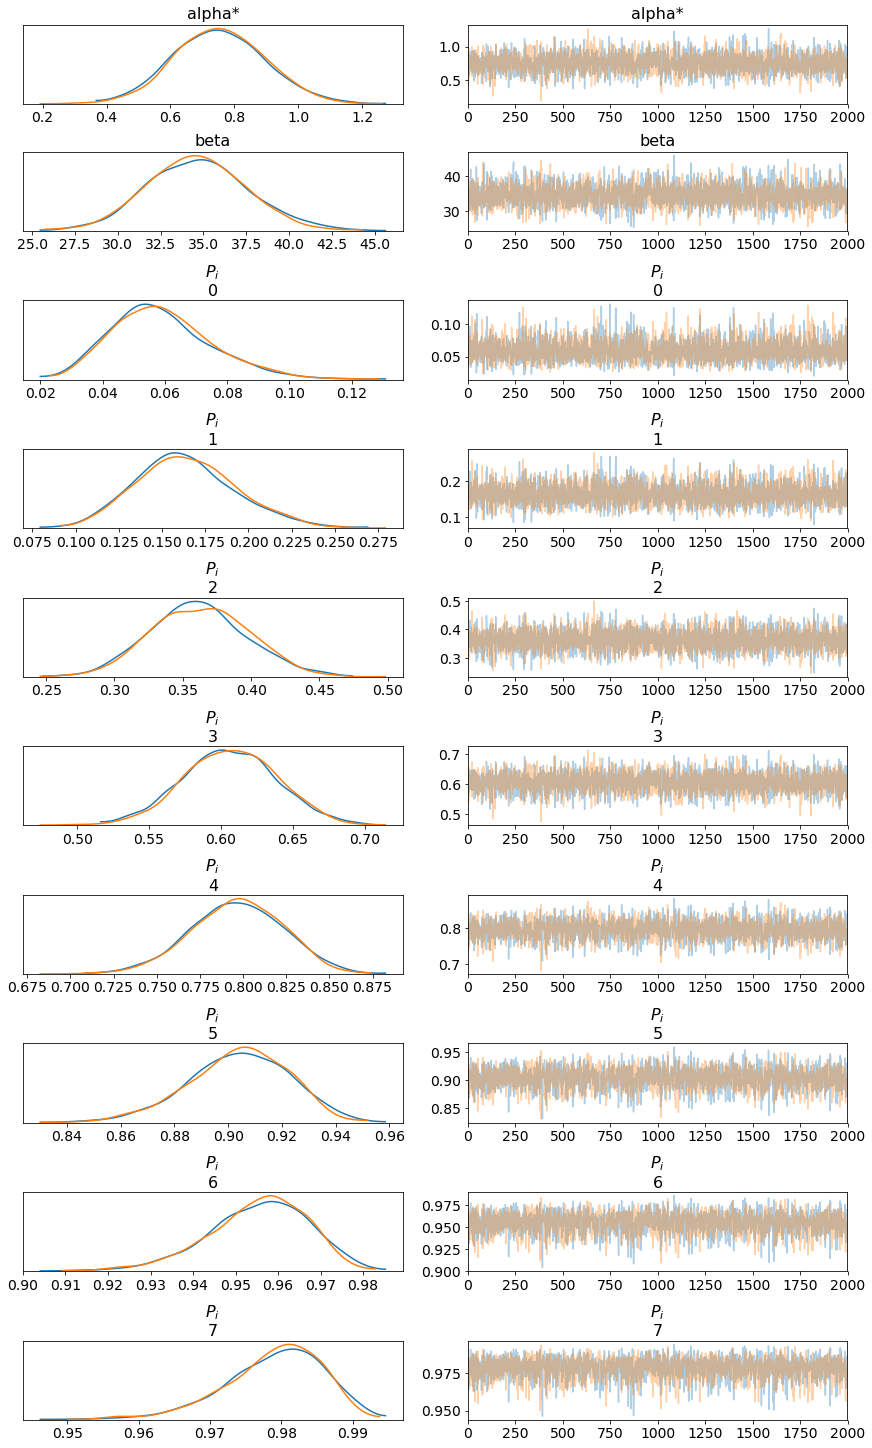

In [8]:
pm.traceplot(trace, compact=False);

In [9]:
def trace_summary(trace, var_names=None):
    if var_names is None:
        var_names = trace.varnames

    quants = [0.025,0.25,0.5,0.75,0.975]
    colnames = ['mean', 'sd', *["{}%".format(x*100) for x in quants]]
    rownames = []

    series = []
    for cur_var in var_names:
        var_trace = trace[cur_var]
        if var_trace.ndim == 1:
            vals = [np.mean(var_trace, axis=0), np.std(var_trace, axis=0), *np.quantile(var_trace, quants, axis=0)]
            series.append(pd.Series(vals, colnames))
            rownames.append(cur_var)
        else:
            for i in range(var_trace.shape[1]):
                cur_col = var_trace[:,i]
                vals = [np.mean(cur_col, axis=0), np.std(cur_col, axis=0), *np.quantile(cur_col, quants, axis=0)]
                series.append(pd.Series(vals, colnames))
                rownames.append("{}[{}]".format(cur_var,i))

    return pd.DataFrame(series, index=rownames)

trace_summary(trace)

,mean,sd,2.5%,25.0%,50.0%,75.0%,97.5%
alpha*,0.751390,0.141753,0.478711,0.652996,0.748475,0.846896,1.033710
beta,34.616909,2.931295,28.936764,32.611365,34.572128,36.488580,40.633339
$P_i$[0],0.059134,0.016350,0.032743,0.047590,0.057312,0.068486,0.096447
$P_i$[1],0.163829,0.028815,0.112463,0.143730,0.161691,0.182162,0.224477
$P_i$[2],0.361563,0.035229,0.294835,0.337852,0.360971,0.384664,0.430386
$P_i$[3],0.605892,0.032435,0.541279,0.583828,0.605457,0.627823,0.668789
$P_i$[4],0.796114,0.026486,0.742425,0.778172,0.796806,0.814523,0.846053
$P_i$[5],0.903587,0.018611,0.863879,0.891767,0.904673,0.917122,0.936220
$P_i$[6],0.955078,0.011669,0.929487,0.947880,0.956265,0.963560,0.974797
$P_i$[7],0.978768,0.006921,0.962938,0.974709,0.979674,0.983812,0.989860


We can also plot the density each chain explored. Any major deviations between chains are signs of difficulty converging.

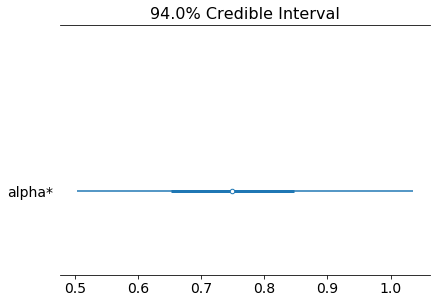

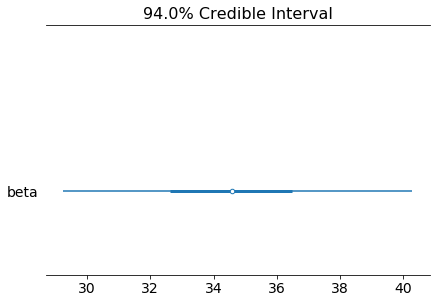

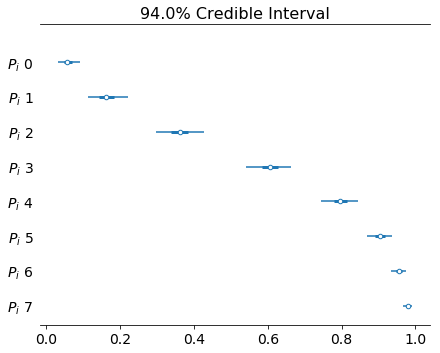

In [10]:
for x in trace.varnames:
    pm.plot_forest(trace, var_names=[x], combined=True)

In addition to the above summaries of the distribution, pymc3 has statistics intended to summarize the quality of the samples. The most common of these is r_hat, which measures whether the different chains seem to be exploring the same space or if they're stuck in different spaces. R-hat above 1.3 is a strong sign the sample isn't good yet. Values close to 1 are ideal.

In [11]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha*,0.751,0.142,0.503,1.035,0.003,0.002,2665.0,2665.0,2665.0,2345.0,1.0
beta,34.617,2.932,29.249,40.277,0.058,0.041,2574.0,2550.0,2591.0,2500.0,1.0
$P_i$[0],0.059,0.016,0.032,0.090,0.000,0.000,3302.0,3211.0,3261.0,2703.0,1.0
$P_i$[1],0.164,0.029,0.112,0.220,0.000,0.000,3520.0,3502.0,3495.0,2802.0,1.0
$P_i$[2],0.362,0.035,0.298,0.427,0.001,0.000,3612.0,3612.0,3596.0,2665.0,1.0
$P_i$[3],0.606,0.032,0.542,0.664,0.001,0.000,2917.0,2917.0,2924.0,2393.0,1.0
$P_i$[4],0.796,0.026,0.745,0.844,0.001,0.000,2369.0,2369.0,2367.0,2337.0,1.0
$P_i$[5],0.904,0.019,0.868,0.937,0.000,0.000,2253.0,2253.0,2254.0,2097.0,1.0
$P_i$[6],0.955,0.012,0.933,0.975,0.000,0.000,2262.0,2262.0,2255.0,2012.0,1.0
$P_i$[7],0.979,0.007,0.966,0.991,0.000,0.000,2294.0,2294.0,2281.0,2258.0,1.0


## Sleep Study

In [14]:
import pandas as pd
sleepstudy = pd.read_csv("sleepstudy.csv")

In [15]:
sleepstudy

,Reaction,Days,Subject
0,249.5600,0,308
1,258.7047,1,308
2,250.8006,2,308
3,321.4398,3,308
4,356.8519,4,308
5,414.6901,5,308
6,382.2038,6,308
7,290.1486,7,308
8,430.5853,8,308
9,466.3535,9,308


In [16]:
# adding a column that numbers the subjects from 0 to n
raw_ids = np.unique(sleepstudy['Subject'])
raw2newid = {x:np.where(raw_ids == x)[0][0] for x in raw_ids}

sleepstudy['SeqSubject'] = sleepstudy['Subject'].map(raw2newid)
sleepstudy

,Reaction,Days,Subject,SeqSubject
0,249.5600,0,308,0
1,258.7047,1,308,0
2,250.8006,2,308,0
3,321.4398,3,308,0
4,356.8519,4,308,0
5,414.6901,5,308,0
6,382.2038,6,308,0
7,290.1486,7,308,0
8,430.5853,8,308,0
9,466.3535,9,308,0


In [17]:
with pm.Model() as sleep_model:
    
    # In this model, we're going to say the alphas (individuals' intercepts; their starting reaction time)
    # and betas (individuals' slopes; how much worse they get with lack of sleep) are normally distributed.
    # We'll specify that we're certain about the mean of those distribution [more on that later], but admit
    # we're uncertain about how much spread there is (i.e. uncertain about the SD). Tau_alpha and Tau_beta 
    # will be the respective SD.
    #
    # Of course, the SDs must be positive (negative SD isn't mathematically possible), so we draw them from
    # a Gamma, which cannot ever output negative numbers. Here, we use alpha and beta values that spread the
    # distribution: "the SD could be anything!". If we had more intuition (e.g. "the starting reaction times can't
    # have SD above 3,000") we would plot Gamma(a,b) and tune the parameters so that there was little mass
    # above 3,000, then use those values below)
    tau_alpha = pm.Gamma('tau_alpha', alpha=.001, beta=.001)
    tau_beta = pm.Gamma('tau_beta', alpha=.001, beta=.001)
    
    # Across the population of people, we suppose that
    # the slopes are normally distributed, as are the intercepts,
    # and the two are drawn independently
    #
    # (Here, we hard-code assumed means, but we don't have to.
    # In general, these should be set from our pre-data intuition,
    # rather than from plots/exploration of the data)
    alpha = pm.Normal('alpha', mu=300, tau=tau_alpha, shape=len(raw_ids))
    beta = pm.Normal('beta', mu=10, tau=tau_beta, shape=len(raw_ids))
    
    # Remember: there's only one alpha/beta per person, but
    # we have lots of observations per person. The below
    # builds a vector with one entry per observation, recording
    # the alpha/beta we want to use with that observation.
    #
    # That is, the length is 180, but it only has 17 unique values,
    # matching the 17 unique patients' personal slopes or intercepts
    intercepts = alpha[sleepstudy['SeqSubject']]
    slopes = beta[sleepstudy['SeqSubject']]
    
    # now we have the true/predicted response time for each observation (each row of original data)
    # (Here we use pm.Deterministic to signal that this is something we'll care about)
    mu_i = pm.Deterministic('mu_i', intercepts + slopes*sleepstudy['Days'])
    
    # The _observed_ values are noisy versions of the hidden true values, however! 
    # Specifically, we model them as a normal at the true value and single unknown variance
    # (one explanation: we're saying the measurement equipment adds normally-distributed noise tau_obs
    # so noise doesn't vary from observation to observation or person to person: there's just one universal
    # noise level)
    tau_obs = pm.Gamma('tau_obs', 0.001, 0.001)
    obs = pm.Normal('observed', mu=mu_i, tau=tau_obs, observed=sleepstudy['Reaction'])
    
    trace = pm.sample(2000, tune=2000, target_accept=0.9)

/usr/local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau_obs, beta, alpha, tau_beta, tau_alpha]
/usr/local/lib/python3.7/site-packages/theano/tensor/subt

In [18]:
# this command can take a few minutes to finish... or never :-/
#pm.traceplot(trace);

In [19]:
trace_summary(trace, var_names=['tau_alpha', 'tau_beta', 'alpha', 'beta', 'tau_obs'])

,mean,sd,2.5%,25.0%,50.0%,75.0%,97.5%
tau_alpha,0.000351,0.000126,0.000157,0.000258,0.000335,0.000424,0.000636
tau_beta,0.032879,0.014897,0.012892,0.022287,0.030065,0.039815,0.070586
alpha[0],257.610159,14.276656,230.115045,247.875540,257.918984,267.516111,284.538994
alpha[1],204.767474,14.186468,176.932727,194.945433,204.590902,214.482879,233.084446
alpha[2],206.308667,13.936264,179.203795,196.948602,206.214474,215.736714,233.825074
alpha[3],284.217173,13.812208,257.704908,275.015790,284.269294,293.375280,312.064149
alpha[4],282.553242,13.794822,255.756413,272.742095,282.844921,292.141532,309.047249
alpha[5],266.389315,13.301735,240.061457,257.526522,266.321948,275.317963,292.045105
alpha[6],275.756079,13.898037,249.559137,266.256139,275.445158,285.073414,302.814478
alpha[7],245.947350,13.812559,220.028833,236.301384,245.823140,255.208295,273.564540


In [20]:
pm.summary(trace, var_names=['tau_alpha', 'tau_beta', 'alpha', 'beta', 'tau_obs'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
tau_alpha,0.000,0.000,0.000,0.001,0.000,0.000,4962.0,4841.0,4570.0,2616.0,1.0
tau_beta,0.033,0.015,0.010,0.060,0.000,0.000,3944.0,3156.0,4351.0,3222.0,1.0
alpha[0],257.610,14.278,230.512,282.679,0.191,0.135,5581.0,5581.0,5596.0,3088.0,1.0
alpha[1],204.767,14.188,179.835,233.325,0.195,0.138,5302.0,5261.0,5327.0,3152.0,1.0
alpha[2],206.309,13.938,179.206,231.732,0.187,0.132,5577.0,5571.0,5577.0,2851.0,1.0
alpha[3],284.217,13.814,257.316,308.996,0.182,0.129,5783.0,5720.0,5783.0,2953.0,1.0
alpha[4],282.553,13.797,257.089,307.915,0.175,0.124,6195.0,6195.0,6239.0,3133.0,1.0
alpha[5],266.389,13.303,240.627,290.772,0.173,0.124,5898.0,5779.0,5944.0,2723.0,1.0
alpha[6],275.756,13.900,249.832,300.624,0.176,0.126,6220.0,6114.0,6217.0,2664.0,1.0
alpha[7],245.947,13.814,220.274,271.449,0.178,0.127,6015.0,5932.0,6058.0,2878.0,1.0


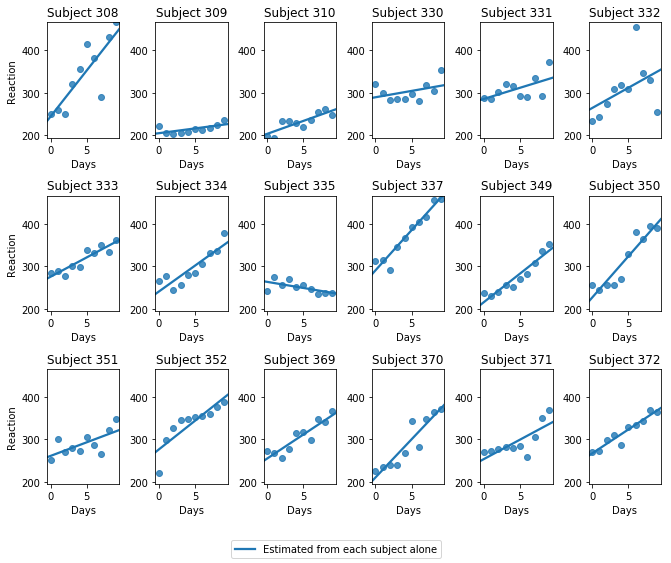

In [21]:
import statsmodels.formula.api as sm
import seaborn as sns
from matplotlib import gridspec


ymin,ymax = np.min(sleepstudy["Reaction"]),np.max(sleepstudy["Reaction"])
plt.figure(figsize=(11,8.5))
gs  = gridspec.GridSpec(3, 6)
gs.update(wspace=0.5, hspace=0.5)
for i, subj in enumerate(np.unique(sleepstudy['Subject'])):
    ss_extract = sleepstudy.loc[sleepstudy['Subject']==subj]
    ss_extract_ols = sm.ols(formula="Reaction~Days",data=ss_extract).fit()
    #new subplot
    subplt = plt.subplot(gs[i])
    #plot without confidence intervals
    sns.regplot(x='Days', y='Reaction', ci=None, data=ss_extract).set_title('Subject '+str(subj))
    if i not in [0,6,12]:
        plt.ylabel("")
    i+=1
    subplt.set_ylim(ymin,ymax)
    
_ = plt.figlegend(['Estimated from each subject alone'],loc = 'lower center', ncol=6)
_ = plt.show()

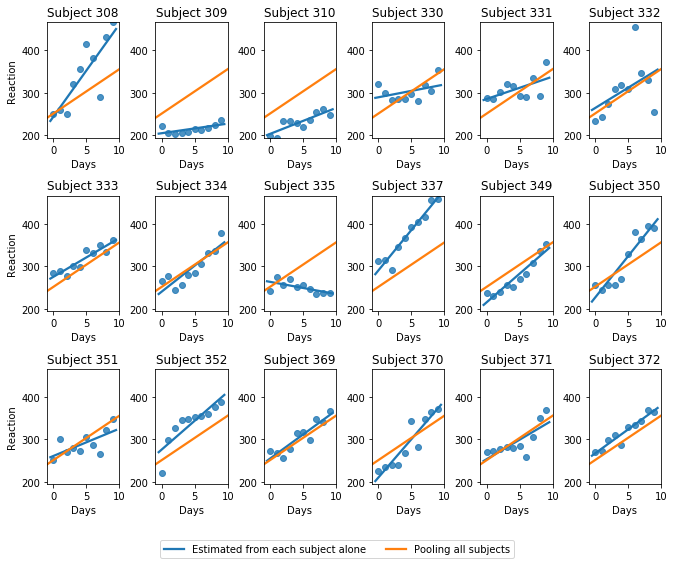

In [22]:
plt.figure(figsize=(11,8.5))
for i, subj in enumerate(np.unique(sleepstudy['Subject'])):
    ss_extract = sleepstudy.loc[sleepstudy['Subject']==subj]
    #new subplot
    subplt = plt.subplot(gs[i])
    #plot without confidence intervals
    sns.regplot(x='Days', y='Reaction', ci=None, data=ss_extract).set_title('Subject '+str(subj)) 
    sns.regplot(x='Days', y='Reaction', ci=None, scatter=False, data=sleepstudy)
    if i not in [0,6,12]:
        plt.ylabel("")
    i+=1
    subplt.set_ylim(ymin,ymax)
    
_ = plt.figlegend(['Estimated from each subject alone','Pooling all subjects'],loc = 'lower center', ncol=6)
_ = plt.show()

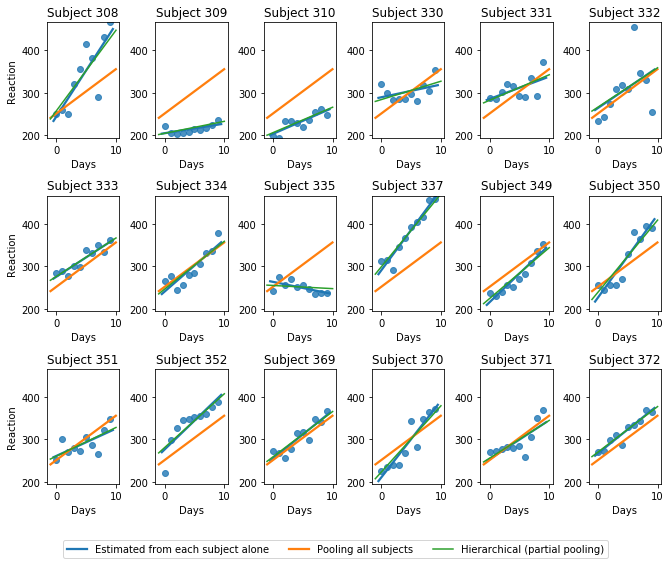

In [23]:
plt.figure(figsize=(11,8.5))
subj_arr = np.unique(sleepstudy['Subject'])
for i, subj in enumerate(subj_arr):
    ss_extract = sleepstudy.loc[sleepstudy['Subject']==subj]
    #new subplot
    subplt = plt.subplot(gs[i])
    
    #plot without confidence intervals
    sns.regplot(x='Days', y='Reaction', ci=None, data=ss_extract).set_title('Subject '+str(subj)) 
    sns.regplot(x='Days', y='Reaction', ci=None, scatter=False, data=sleepstudy)
    
    subj_num = int(np.where(subj_arr==subj)[0])
    
    subjects_avg_intercept = np.mean(trace['alpha'][:,i])
    subjects_avg_slope = np.mean(trace['beta'][:,i])
    hmodel_fit = [subjects_avg_intercept + subjects_avg_slope*x for x in range(-1,11)]
    sns.lineplot(x=range(-1,11),y=hmodel_fit)
    if i not in [0,6,12]:
        plt.ylabel("")
    i+=1
    subplt.set_ylim(ymin,ymax)
    
_ = plt.figlegend(['Estimated from each subject alone','Pooling all subjects','Hierarchical (partial pooling)'],loc = 'lower center', ncol=6)
_ = plt.show()

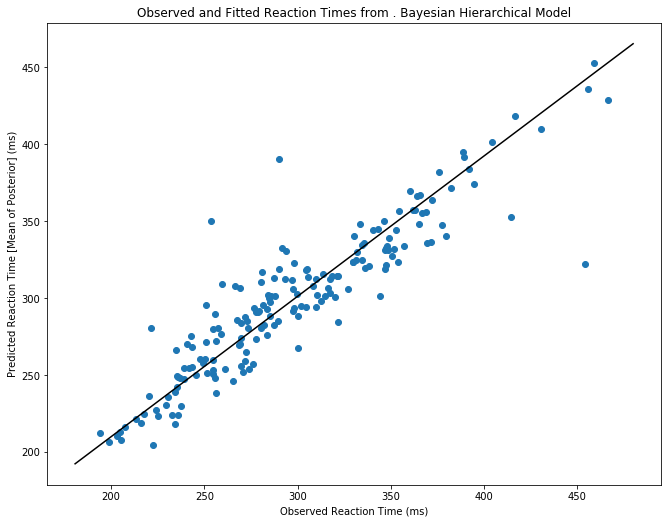

In [24]:
model_predictions = trace['mu_i'].mean(axis=0)
obs_reactions = sleepstudy['Reaction']

plt.figure(figsize=(11,8.5))
plt.scatter(sleepstudy['Reaction'], model_predictions)
plt.plot(plt.xlim(), plt.ylim(), c='black')
plt.xlabel("Observed Reaction Time (ms)")
plt.ylabel("Predicted Reaction Time [Mean of Posterior] (ms)")
plt.title("Observed and Fitted Reaction Times from . Bayesian Hierarchical Model")
plt.show()